In [ ]:
#LM-O
output_dir = '/Workspace/Data/Example/outputs'
cad_path = '/Workspace/Data/Example/obj_000005.ply'
rgb_path = '/Workspace/Data/Example/rgb.png'
depth_path = '/Workspace/Data/Example/depth.png'
cam_path = '/Workspace/Data/Example/camera.json'

In [ ]:
#YCBV
output_dir = '/Workspace/Data/Example_ycbv/outputs'
cad_path = '/Workspace/Data/Example_ycbv/obj_000015.ply'
rgb_path = '/Workspace/Data/Example_ycbv/rgb.png'
depth_path = '/Workspace/Data/Example_ycbv/depth.png'
cam_path = '/Workspace/Data/Example_ycbv/camera.json'

In [1]:
#TLESS
output_dir = '/Workspace/Data/Example_tless/outputs'
cad_path = '/Workspace/Data/Example_tless/obj_000005.ply'
rgb_path = '/Workspace/Data/Example_tless/rgb.png'
depth_path = '/Workspace/Data/Example_tless/depth.png'
cam_path = '/Workspace/Data/Example_tless/camera.json'

In [2]:
segmentor_model = 'sam'
#segmentor_model = 'fastsam'
stability_score_thresh = 0.97

In [3]:
import argparse
import cv2
import distinctipy
import glob
import imageio.v2 as imageio
import logging
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import os.path as osp
import shutil
import time
import torch
import torchvision.transforms as T
import trimesh

In [4]:
logging.basicConfig(level=logging.INFO)

In [5]:
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from segment_anything.utils.amg import rle_to_mask
from skimage.feature import canny
from skimage.morphology import binary_dilation
from torchvision.utils import save_image
from tqdm import tqdm

In [6]:
sys.path.append('/code/SAM-6D/Instance_Segmentation_Model')

In [7]:
from model.loss import Similarity
from model.utils import Detections, convert_npz_to_json
from utils.bbox_utils import CropResizePad
from utils.inout import load_json, save_json_bop23
from utils.poses.pose_utils import get_obj_poses_from_template_level, load_index_level_in_level2

In [8]:
inv_rgb_transform = T.Compose(
        [
            T.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
            ),
        ]
    )

In [9]:
def visualize(rgb, detections, save_path="tmp.png"):
    img = rgb.copy()
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    colors = distinctipy.get_colors(len(detections))
    alpha = 0.33

    best_score = 0.
    for mask_idx, det in enumerate(detections):
        if best_score < det['score']:
            best_score = det['score']
            best_det = detections[mask_idx]

    mask = rle_to_mask(best_det["segmentation"])
    edge = canny(mask)
    edge = binary_dilation(edge, np.ones((2, 2)))
    obj_id = best_det["category_id"]
    temp_id = obj_id - 1

    r = int(255*colors[temp_id][0])
    g = int(255*colors[temp_id][1])
    b = int(255*colors[temp_id][2])
    img[mask, 0] = alpha*r + (1 - alpha)*img[mask, 0]
    img[mask, 1] = alpha*g + (1 - alpha)*img[mask, 1]
    img[mask, 2] = alpha*b + (1 - alpha)*img[mask, 2]   
    img[edge, :] = 255
    
    img = Image.fromarray(np.uint8(img))
    img.save(save_path)
    prediction = Image.open(save_path)
    
    # concat side by side in PIL
    img = np.array(img)
    concat = Image.new('RGB', (img.shape[1] + prediction.size[0], img.shape[0]))
    concat.paste(rgb, (0, 0))
    concat.paste(prediction, (img.shape[1], 0))
    return concat

In [10]:
def batch_input_data(depth_path, cam_path, device):
    batch = {}
    cam_info = load_json(cam_path)
    depth = np.array(imageio.imread(depth_path)).astype(np.int32)
    cam_K = np.array(cam_info['cam_K']).reshape((3, 3))
    depth_scale = np.array(cam_info['depth_scale'])

    batch["depth"] = torch.from_numpy(depth).unsqueeze(0).to(device)
    batch["cam_intrinsic"] = torch.from_numpy(cam_K).unsqueeze(0).to(device)
    batch['depth_scale'] = torch.from_numpy(depth_scale).unsqueeze(0).to(device)
    return batch

In [11]:
os.makedirs(f"{output_dir}/sam6d_results", exist_ok=True)
os.chdir('/code/SAM-6D/Instance_Segmentation_Model')

In [12]:
with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs"):
    cfg = compose(config_name='run_inference.yaml')

In [13]:
if segmentor_model == "sam":
    with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs/model"):
        cfg.model = compose(config_name='ISM_sam.yaml')
    cfg.model.segmentor_model.stability_score_thresh = stability_score_thresh
elif segmentor_model == "fastsam":
    with initialize(version_base=None, config_path="../code/SAM-6D/Instance_Segmentation_Model/configs/model"):
        cfg.model = compose(config_name='ISM_fastsam.yaml')
else:
    raise ValueError("The segmentor_model {} is not supported now!".format(segmentor_model))

/opt/conda/envs/sam6d/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'ISM_sam.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [14]:
logging.info("Initializing model")
model = instantiate(cfg.model)

INFO:root:Initializing model
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpxydhbc9a
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpxydhbc9a/_remote_module_non_scriptable.py
INFO:root:Loading SAM model from ./checkpoints/segment-anything/
INFO:root:Init CustomSamAutomaticMaskGenerator done!
INFO:dinov2:using MLP layer as FFN
INFO:root:Init CustomDINOv2 done!
INFO:root:Init CustomDINOv2 with full size=640 and proposal size=224 done!
INFO:root:Init CNOS done!


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.descriptor_model.model = model.descriptor_model.model.to(device)
model.descriptor_model.model.device = device
# if there is predictor in the model, move it to device
if hasattr(model.segmentor_model, "predictor"):
    model.segmentor_model.predictor.model = (
        model.segmentor_model.predictor.model.to(device)
    )
else:
    model.segmentor_model.model.setup_model(device=device, verbose=True)
logging.info(f"Moving models to {device} done!")

INFO:root:Moving models to cuda done!


In [16]:
logging.info("Initializing template")
template_dir = os.path.join(output_dir, 'templates')
num_templates = len(glob.glob(f"{template_dir}/*.npy"))
boxes, masks, templates = [], [], []
for idx in range(num_templates):
    image = Image.open(os.path.join(template_dir, 'rgb_'+str(idx)+'.png'))
    mask = Image.open(os.path.join(template_dir, 'mask_'+str(idx)+'.png'))
    boxes.append(mask.getbbox())

    image = torch.from_numpy(np.array(image.convert("RGB")) / 255).float()
    mask = torch.from_numpy(np.array(mask.convert("L")) / 255).float()
    image = image * mask[:, :, None]
    templates.append(image)
    masks.append(mask.unsqueeze(-1))
    
templates = torch.stack(templates).permute(0, 3, 1, 2)
masks = torch.stack(masks).permute(0, 3, 1, 2)
boxes = torch.tensor(np.array(boxes))

processing_config = OmegaConf.create(
    {
        "image_size": 224,
    }
)
proposal_processor = CropResizePad(processing_config.image_size)
templates = proposal_processor(images=templates, boxes=boxes).to(device)
masks_cropped = proposal_processor(images=masks, boxes=boxes).to(device)

model.ref_data = {}
model.ref_data["descriptors"] = model.descriptor_model.compute_features(
                templates, token_name="x_norm_clstoken"
            ).unsqueeze(0).data
model.ref_data["appe_descriptors"] = model.descriptor_model.compute_masked_patch_feature(
                templates, masks_cropped[:, 0, :, :]
            ).unsqueeze(0).data

INFO:root:Initializing template


In [17]:
# run inference
rgb = Image.open(rgb_path).convert("RGB")
detections = model.segmentor_model.generate_masks(np.array(rgb))
detections = Detections(detections)
query_decriptors, query_appe_descriptors = model.descriptor_model.forward(np.array(rgb), detections)

In [18]:
# matching descriptors
(
    idx_selected_proposals,
    pred_idx_objects,
    semantic_score,
    best_template,
) = model.compute_semantic_score(query_decriptors)

In [19]:
# update detections
detections.filter(idx_selected_proposals)
query_appe_descriptors = query_appe_descriptors[idx_selected_proposals, :]

In [20]:
# compute the appearance score
appe_scores, ref_aux_descriptor= model.compute_appearance_score(best_template, pred_idx_objects, query_appe_descriptors)

In [21]:
# compute the geometric score
batch = batch_input_data(depth_path, cam_path, device)
template_poses = get_obj_poses_from_template_level(level=2, pose_distribution="all")
template_poses[:, :3, 3] *= 0.4
poses = torch.tensor(template_poses).to(torch.float32).to(device)
model.ref_data["poses"] =  poses[load_index_level_in_level2(0, "all"), :, :]

mesh = trimesh.load_mesh(cad_path)
model_points = mesh.sample(2048).astype(np.float32) / 1000.0
model.ref_data["pointcloud"] = torch.tensor(model_points).unsqueeze(0).data.to(device)

image_uv = model.project_template_to_image(best_template, pred_idx_objects, batch, detections.masks)

geometric_score, visible_ratio = model.compute_geometric_score(
    image_uv, detections, query_appe_descriptors, ref_aux_descriptor, visible_thred=model.visible_thred
    )

In [22]:
# final score
final_score = (semantic_score + appe_scores + geometric_score*visible_ratio) / (1 + 1 + visible_ratio)

detections.add_attribute("scores", final_score)
detections.add_attribute("object_ids", torch.zeros_like(final_score)) 

In [30]:
detections.scores

tensor([0.6752, 0.5870, 0.3467, 0.2722, 0.5873, 0.5360], device='cuda:0')

In [28]:
cfg.model.post_processing_config.mask_post_processing

{'min_box_size': 0.1, 'min_mask_size': 0.02}

In [27]:
cfg.model.post_processing_config.mask_post_processing.min_box_size = 0.1
cfg.model.post_processing_config.mask_post_processing.min_mask_size = 0.02

In [29]:
detections.remove_very_small_detections(cfg.model.post_processing_config.mask_post_processing)

In [31]:
detections.to_numpy()

In [32]:
save_path = f"{output_dir}/sam6d_results/detection_ism"
detections.save_to_file(0, 0, 0, save_path, "Custom", return_results=False)
detections = convert_npz_to_json(idx=0, list_npz_paths=[save_path+".npz"])
save_json_bop23(save_path+".json", detections)
vis_img = visualize(rgb, detections, f"{output_dir}/sam6d_results/vis_ism.png")
vis_img.save(f"{output_dir}/sam6d_results/vis_ism.png")

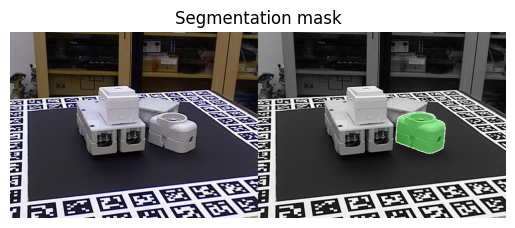

In [33]:
plt.imshow(vis_img)
plt.axis('off')
plt.title("Segmentation mask")
plt.show()